In [3]:
!nvidia-smi

Tue Mar 26 05:05:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |     80MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import gc
from os.path import join as pjoin
import os
from datetime import datetime
import time

In [13]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy,ShowGraph
import torch

## Prepare for loging

In [6]:
import json
import os.path
import re
import ipykernel
import requests


from requests.compat import urljoin

from notebook.notebookapp import list_running_servers

def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path


from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    print('This notebook has been saved')



In [7]:
# vars for models logging

TRAIN_LOG_DIR = 'train_log'
MODEL_NAME = get_notebook_name().split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0])
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
save_folder = f"{version:0>3d}" +'.'+date
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,save_folder)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/resnet18-fastai/004.26-03-2019-05-05'

In [8]:
print(f"""
Note for version {version} model {MODEL_NAME}:

""")


Note for version 4 model resnet18-fastai:




# Init data loader

In [9]:
data_path = './data/'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,size=48,ds_tfms=tfms,bs=16,test='test')
       .normalize())

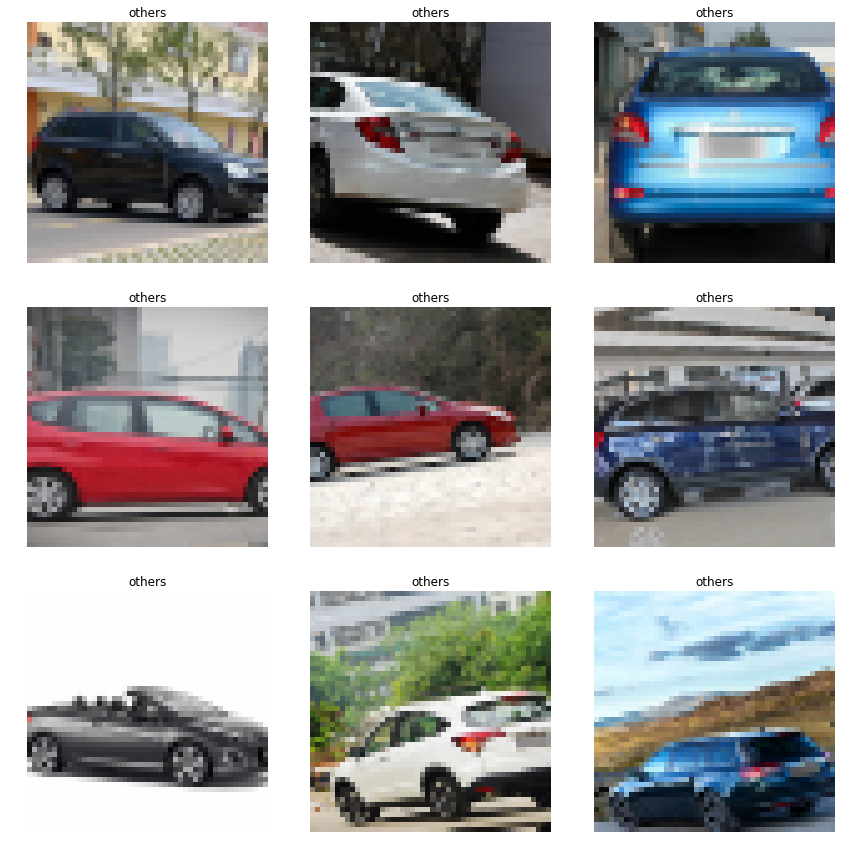

In [10]:
data.show_batch(rows=3)

In [11]:
model = models.resnet18

In [14]:
learn = cnn_learner(data, model,callback_fns=ShowGraph)

In [15]:
### THE DIRECTORY TO SAVE CHECKPOINTS
learn.model_dir = os.path.abspath(model_save_dir)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


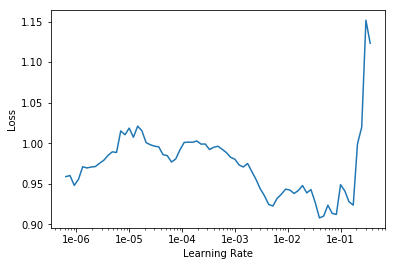

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr=1e-2
learn.metrics = [accuracy]

epoch,train_loss,valid_loss,accuracy,time
0,0.495728,0.464089,0.834235,00:37
1,0.519117,0.470871,0.824397,00:36
2,0.433802,0.399521,0.830792,00:36
3,0.415851,0.383808,0.839646,00:37
4,0.377384,0.399370,0.840630,00:36
5,0.362179,0.452077,0.835219,00:37


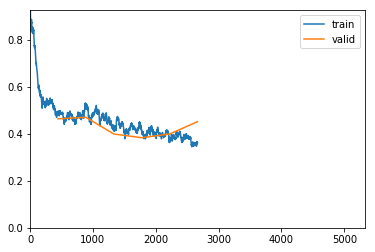

In [ ]:
learn.fit_one_cycle(12,slice(lr))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.fit(6)

In [ ]:
learn.save('stage-2')

# Unfreeze

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit(12)

In [ ]:
learn.save('stage-3')

# Refreeze

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(9)

In [ ]:
learn.save('stage-4')

In [ ]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

# Round 2

In [ ]:
data_path = './data/'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,size=96,ds_tfms=tfms,bs=16,test='test')
       .normalize())

In [ ]:
learn.data = data

In [ ]:
learn.save('stage-5')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(9,lr)

In [ ]:
learn.save('stage-6')

# Unfreeze

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(9)


# Refreeze

In [ ]:
learn.freeze()

In [ ]:
learn.save('stage-7')

In [ ]:
learn.fit(9)

In [ ]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

In [ ]:
notebook_save()
time.sleep(3) # to save the checkpoint
nb_name = model_save_dir+'_acc_'+str(tta)[:4]+'.html'
os.system(f"jupyter nbconvert {get_notebook_name()} --output {nb_name}")
nb_name